In [95]:
import janus
import os
import timeit
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_bvp
from scipy.signal import argrelmax,find_peaks,argrelmin
import imp
from scipy.sparse import csr_matrix
plt.rcParams.update({'font.size': 12, 'pdf.fonttype':42,'text.usetex': False, 'font.family': 'serif'})
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

imp.reload(janus)

<module 'janus' from '/Users/zack/Documents/oscillators/snakingoscillators/janus.py'>

### A limit-cycle chimera state

runtime: 37.265329


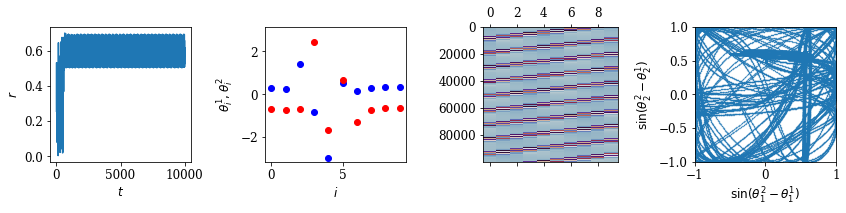

In [2]:
N=10
k=1
t1=10000
t3=9000
dt=0.01
sigma=0.35
beta=0.25
gamma=0.1
output=2
seed=1
omega=1

np.random.seed(seed)
phase_init = np.zeros(4*N,dtype=np.float64)
phi0=-np.pi+2*np.pi*np.random.random(N)
phi1=-np.pi+2*np.pi*np.random.random(N)
phase_init[:N] = np.cos(phi0)
phase_init[N:2*N] = np.sin(phi0)
phase_init[2*N:3*N] = np.cos(phi1)
phase_init[3*N:] = np.sin(phi1)

start = timeit.default_timer()
phases,times,order=janus.runsim(N, t1, t3, dt, omega, beta, sigma, gamma, phase_init)
stop = timeit.default_timer()
print('runtime: %f' % (stop - start))

phases=phases[int(t3/dt):]

phi0=np.arctan2(phases[:,N:2*N],phases[:,:N])
phi1=np.arctan2(phases[:,3*N:],phases[:,2*N:3*N])

plt.subplots(1,4,figsize=(12,3))
plt.subplot(1,4,1)
plt.xlabel('$t$')
plt.ylabel('$r$')
plt.plot(times,order)
plt.subplot(1,4,2)
plt.xlabel('$i$')
plt.ylabel(r'$\theta_i^1, \theta_i^2$')
plt.ylim(-np.pi,np.pi)
plt.plot(phi0[-1],'bo')
plt.plot(phi1[-1],'ro')
plt.subplot(1,4,3)
ratio=N/len(phases)
plt.gca().matshow(phi1,aspect=ratio,vmin=-np.pi,vmax=np.pi,cmap='twilight_shifted')
plt.subplot(1,4,4)
plt.xlabel(r'$\sin(\theta_1^2-\theta_1^1)$')
plt.ylabel(r'$\sin(\theta_2^2-\theta_2^1)$')
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.scatter(np.cos(phi1[:,0]-phi0[:,0]),np.cos(phi1[:,1]-phi0[:,1]),s=0.1)
plt.tight_layout()
plt.show()

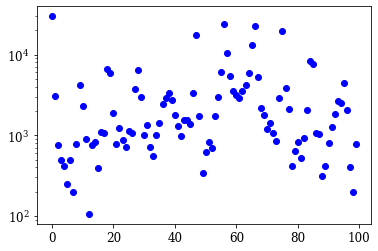

In [3]:
plt.yscale('log')
plt.plot(np.abs(np.fft.fft(phi0,axis=0))[:100,0],'bo')

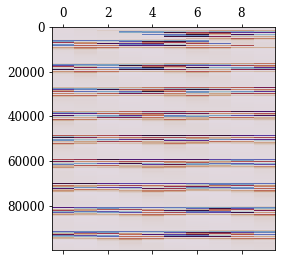

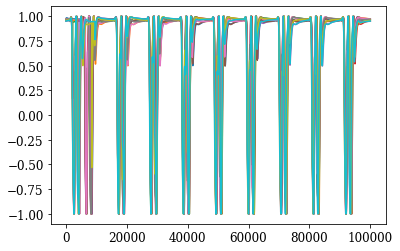

In [4]:
nu=10.5/dt
plt.matshow(np.transpose([np.cos(np.roll(phi0[:,i], 100+int(nu*i))) for i in range(N)]),aspect=len(phi0[0])/len(phi0),cmap='twilight')
plt.show()
plt.plot(np.transpose([np.cos(np.roll(phi0[:,i], 100+int(nu*i))) for i in range(N)]))
plt.show()

### A chaotic or invariant torus chimera state

runtime: 38.406073


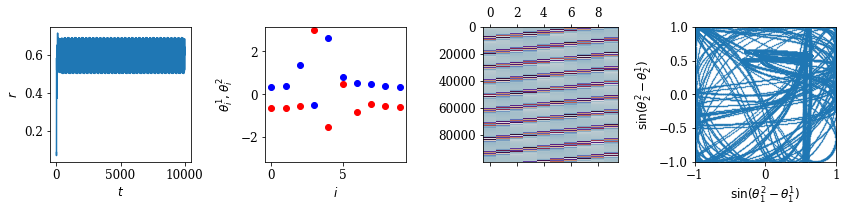

In [5]:
N=10
k=1
t1=10000
t3=9000
dt=0.01
sigma=0.35
beta=0.25
gamma=0.1
output=2
seed=9
omega=1

np.random.seed(seed)
phase_init = np.zeros(4*N,dtype=np.float64)
phi0=-np.pi+2*np.pi*np.random.random(N)
phi1=-np.pi+2*np.pi*np.random.random(N)
phase_init[:N] = np.cos(phi0)
phase_init[N:2*N] = np.sin(phi0)
phase_init[2*N:3*N] = np.cos(phi1)
phase_init[3*N:] = np.sin(phi1)

start = timeit.default_timer()
phases,times,order=janus.runsim(N, t1, t3, dt, omega, beta, sigma, gamma, phase_init)
stop = timeit.default_timer()
print('runtime: %f' % (stop - start))

phases=phases[int(t3/dt):]

phi0=np.arctan2(phases[:,N:2*N],phases[:,:N])
phi1=np.arctan2(phases[:,3*N:],phases[:,2*N:3*N])

plt.subplots(1,4,figsize=(12,3))
plt.subplot(1,4,1)
plt.xlabel('$t$')
plt.ylabel('$r$')
plt.plot(times,order)
plt.subplot(1,4,2)
plt.xlabel('$i$')
plt.ylabel(r'$\theta_i^1, \theta_i^2$')
plt.ylim(-np.pi,np.pi)
plt.plot(phi0[-1],'bo')
plt.plot(phi1[-1],'ro')
plt.subplot(1,4,3)
ratio=N/len(phases)
plt.gca().matshow(phi1,aspect=ratio,vmin=-np.pi,vmax=np.pi,cmap='twilight_shifted')
plt.subplot(1,4,4)
plt.xlabel(r'$\sin(\theta_1^2-\theta_1^1)$')
plt.ylabel(r'$\sin(\theta_2^2-\theta_2^1)$')
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.scatter(np.cos(phi1[:,0]-phi0[:,0]),np.cos(phi1[:,1]-phi0[:,1]),s=0.1)
plt.tight_layout()
plt.show()

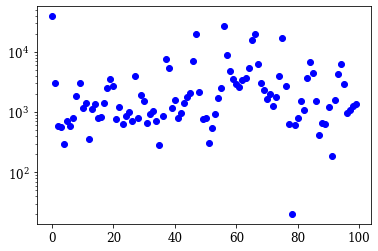

In [6]:
plt.yscale('log')
plt.plot(np.abs(np.fft.fft(phi0,axis=0))[:100,0],'bo')

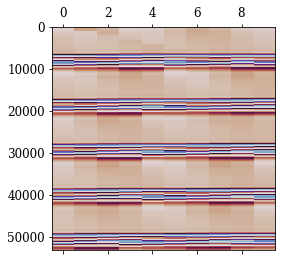

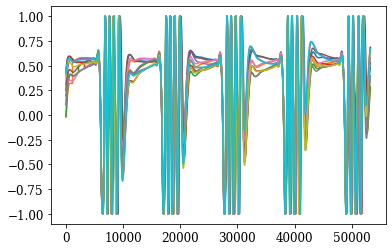

In [7]:
nmax=5*(int(len(phases)/10)+650)

phi0=np.arctan2(phases[:nmax,N:2*N],phases[:nmax,:N])
phi1=np.arctan2(phases[:nmax,3*N:],phases[:nmax,2*N:3*N])

nu=10.5/dt
plt.matshow(np.transpose([np.cos(np.roll(phi1[:,i], 100+int(nu*i))) for i in range(N)]),aspect=len(phi0[0])/len(phi0),cmap='twilight')
plt.show()
plt.plot(np.transpose([np.cos(np.roll(phi1[:,i], 100+int(nu*i))-phi0[:,0]) for i in range(N)]))
plt.show()

### Continue a limit cycle chimera

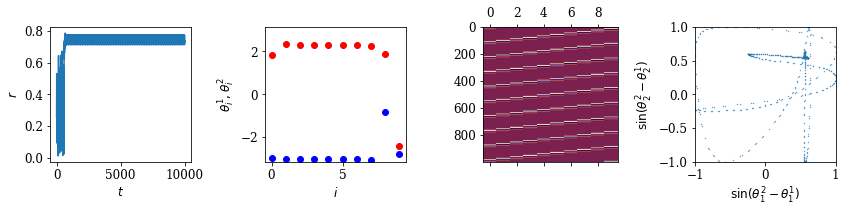

(array([ 6, 13, 20, 27, 34, 41, 48, 55, 62]),)

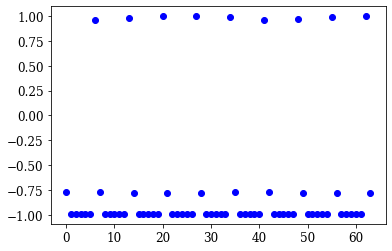

In [96]:
filebase='data/chimera/'
times=np.load(filebase+'times.npy')
order=np.load(filebase+'order.npy')
phases=np.load(filebase+'phases.npy')
fs=np.load(filebase+'fs.npy')
N=int((len(fs)+2)/4)
sigma0=0.35
omega=1
beta=0.25
gamma=0.1
phi0=np.arctan2(phases[:,N:2*N],phases[:,:N])
phi1=np.arctan2(phases[:,3*N:],phases[:,2*N:3*N])

plt.subplots(1,4,figsize=(12,3))
plt.subplot(1,4,1)
plt.xlabel('$t$')
plt.ylabel('$r$')
plt.plot(times,order)
plt.subplot(1,4,2)
plt.xlabel('$i$')
plt.ylabel(r'$\theta_i^1, \theta_i^2$')
plt.ylim(-np.pi,np.pi)
plt.plot(phi0[-1],'bo')
plt.plot(phi1[-1],'ro')
plt.subplot(1,4,3)
ratio=N/len(phases)
plt.gca().matshow(phi1,aspect=ratio,vmin=-np.pi,vmax=np.pi,cmap='twilight_shifted')
plt.subplot(1,4,4)
plt.xlabel(r'$\sin(\theta_1^2-\theta_1^1)$')
plt.ylabel(r'$\sin(\theta_2^2-\theta_2^1)$')
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.scatter(np.cos(phi1[:,0]-phi0[:,0]),np.cos(phi1[:,1]-phi0[:,1]),s=0.1)
plt.tight_layout()
plt.show()

minds=find_peaks(phases[:,0])[0]
plt.plot(phases[minds,0],'bo')
np.where(phases[minds,0]>0.9)

In [13]:
imp.reload(janus)

<module 'janus' from '/Users/zack/Documents/oscillators/snakingoscillators/janus.py'>

The algorithm converged to the desired accuracy.
0.350000	5.000e-04	140	110.168162	5	8.371849	
0.350500	5.000e-04	156	110.665182	6	9.407027	
0.351000	5.000e-04	317	111.157444	4	7.108437	
0.351500	5.000e-04	317	111.649359	1	5.398563	
0.352000	5.000e-04	317	112.148423	1	5.452663	
0.352500	5.000e-04	317	112.655217	1	6.015440	
Trying to increase step and coarsen.
0.353500	1.000e-03	317	113.692843	2	3.358585	
0.354500	1.000e-03	317	114.765184	1	5.360820	
0.355500	1.000e-03	317	115.876532	1	5.200897	
0.356500	1.000e-03	317	117.030127	1	5.205871	
0.357500	1.000e-03	317	118.230572	1	5.222395	
Trying to increase step and coarsen.
0.358500	1.000e-03	317	119.484225	2	3.340584	
0.359500	1.000e-03	317	120.796144	1	6.170181	
0.360500	1.000e-03	317	122.174602	1	6.789742	
0.361500	1.000e-03	317	123.629578	1	6.824644	
0.362500	1.000e-03	317	125.173195	1	5.579608	
Trying to increase step and coarsen.
0.363500	1.000e-03	320	126.820493	4	21.255425	
0.364500	1.000e-03	321	128.592578	2	12.938167	
0.365500	1

/Users/zack/opt/anaconda3/envs/oscillator_env/lib/python3.9/site-packages/scipy/optimize/minpack.py:475: RuntimeWarning: Number of calls to function has reached maxfev = 800.
  warnings.warn(errors[info][0], RuntimeWarning)


0.365500	-1.000e-03	1729	296.513343	2	26.318950	
0.364500	-1.000e-03	1729	310.985839	1	26.806215	
0.363500	-1.000e-03	1729	325.831757	1	28.429643	
0.362500	-1.000e-03	1729	341.369785	1	22.553910	
Trying to increase step and coarsen.
0.361500	-1.000e-03	925	358.471370	4	49.811401	
0.360500	-1.000e-03	1878	376.548599	3	64.531306	
The maximum number of mesh nodes is exceeded.
0.360500	-5.000e-04	1878	376.548599	3	26.448179	
The maximum number of mesh nodes is exceeded.
0.360500	-2.500e-04	1878	376.548599	3	28.909820	
0.360250	-2.500e-04	1878	381.296778	1	25.995010	
0.360000	-2.500e-04	1878	386.168706	1	23.388861	
0.359750	-2.500e-04	1878	391.162061	1	23.239288	
0.359500	-2.500e-04	1878	396.284584	1	24.818847	
0.359250	-2.500e-04	1878	401.558572	1	23.141082	
Trying to increase step and coarsen.
0.358750	-5.000e-04	1744	412.796250	29	582.874781	
The maximum number of mesh nodes is exceeded.
0.358750	-2.500e-04	1744	412.796250	29	30.334298	
0.358500	-2.500e-04	1744	418.584659	1	22.955191	
Th

/Users/zack/Documents/oscillators/snakingoscillators/janus.py:24: RuntimeWarning: overflow encountered in multiply
  dydt= x*(omega/2-beta*(-x*v+y*u)-sigmat*(-x*np.roll(v,-1)+y*np.roll(u,-1)))+gamma*(1-x**2-y**2)*y
/Users/zack/Documents/oscillators/snakingoscillators/janus.py:24: RuntimeWarning: invalid value encountered in add
  dydt= x*(omega/2-beta*(-x*v+y*u)-sigmat*(-x*np.roll(v,-1)+y*np.roll(u,-1)))+gamma*(1-x**2-y**2)*y
/Users/zack/Documents/oscillators/snakingoscillators/janus.py:25: RuntimeWarning: overflow encountered in multiply
  dudt=-v*(-omega/2-beta*(x*v-y*u)-sigmat*(np.roll(x,1)*v-np.roll(y,1)*u))+gamma*(1-u**2-v**2)*u
/Users/zack/Documents/oscillators/snakingoscillators/janus.py:25: RuntimeWarning: invalid value encountered in add
  dudt=-v*(-omega/2-beta*(x*v-y*u)-sigmat*(np.roll(x,1)*v-np.roll(y,1)*u))+gamma*(1-u**2-v**2)*u
/Users/zack/Documents/oscillators/snakingoscillators/janus.py:26: RuntimeWarning: overflow encountered in multiply
  dvdt= u*(-omega/2-beta*(x*v-y

/Users/zack/Documents/oscillators/snakingoscillators/janus.py:64: RuntimeWarning: overflow encountered in subtract
  
/Users/zack/Documents/oscillators/snakingoscillators/janus.py:46: RuntimeWarning: overflow encountered in subtract
  Jxy=(-(omega/2-beta*(-x*v+2*y*u)-sigmat*(-x*np.roll(v,-1)+2*y*np.roll(u,-1)))+gamma*(-2*y)*x)*I1
/Users/zack/Documents/oscillators/snakingoscillators/janus.py:58: RuntimeWarning: overflow encountered in subtract
  Juv=(-(-omega/2-beta*(2*x*v-y*u)-sigmat*(2*np.roll(x,1)*v-np.roll(y,1)*u))+gamma*(-2*v)*u)*I1
/Users/zack/Documents/oscillators/snakingoscillators/janus.py:51: RuntimeWarning: overflow encountered in add
  Jyy=(x*(omega/2-beta*(u)-sigmat*(np.roll(u,-1)))+gamma*(1-x**2-3*y**2))*I1
/Users/zack/Documents/oscillators/snakingoscillators/janus.py:59: RuntimeWarning: overflow encountered in subtract
  # dvdt= u*(-omega/2-beta*(x*v-y*u)-sigmat*(np.roll(x,1)*v-np.roll(y,1)*u))+gamma*(1-u**2-v**2)*v
/Users/zack/Documents/oscillators/snakingoscillators/jan

A singular Jacobian encountered when solving the collocation system.
0.355375	-1.563e-05	964	519.027040	2	35.213219	


/Users/zack/opt/anaconda3/envs/oscillator_env/lib/python3.9/site-packages/scipy/integrate/_bvp.py:566: RuntimeWarning: invalid value encountered in true_divide
  r_middle /= 1 + np.abs(f_middle)
/Users/zack/opt/anaconda3/envs/oscillator_env/lib/python3.9/site-packages/scipy/integrate/_bvp.py:567: RuntimeWarning: invalid value encountered in true_divide
  r1 /= 1 + np.abs(f1)
/Users/zack/opt/anaconda3/envs/oscillator_env/lib/python3.9/site-packages/scipy/integrate/_bvp.py:568: RuntimeWarning: invalid value encountered in true_divide
  r2 /= 1 + np.abs(f2)


The maximum number of mesh nodes is exceeded.
0.355375	-7.813e-06	964	519.027040	2	42.353115	


/Users/zack/Documents/oscillators/snakingoscillators/janus.py:52: RuntimeWarning: overflow encountered in add
  Jyu=x*(-beta*(y*I1)-sigmat*(y*I2))
/Users/zack/Documents/oscillators/snakingoscillators/janus.py:64: RuntimeWarning: overflow encountered in add
  


A singular Jacobian encountered when solving the collocation system.
0.355375	-3.906e-06	964	519.027040	2	32.149752	
The maximum number of mesh nodes is exceeded.
0.355375	-1.953e-06	964	519.027040	2	42.726498	
The maximum number of mesh nodes is exceeded.
0.355375	-9.766e-07	964	519.027040	2	27.596291	
step size too small
runtime:  2591.8460766


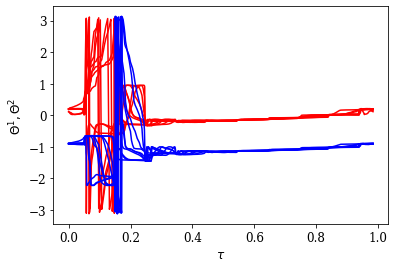

In [94]:
m0=6
m1=13
p0=times[minds[m1]]-times[minds[m0]]
x0=(times[minds[m0]:minds[m1]]-times[minds[m0]])/p0
y0=phases[minds[m0]:minds[m1]].T
sigma=sigma0
dsigma=0.5e-3
dsigmamax=1e-3
dsigmamin=1e-6
sigmamin=0.25
sigmamax=0.4
start=timeit.default_timer()
sigmas,sols=janus.cont(filebase,omega,beta,gamma,sigma,x0,y0,p0,sigmamin,sigmamax,dsigma,maxnodes=2000)
stop=timeit.default_timer()
print("runtime: ",stop-start)
phases=sols[-1].y.T.copy()
phi=np.arctan2(phases[:,3*N:],phases[:,2*N:3*N])
theta=np.arctan2(phases[:,N:2*N],phases[:,:N])
plt.xlabel(r'$\tau$')
plt.ylabel(r'$\Theta^1, \Theta^2$')
plt.plot(sols[-1].x, np.transpose([np.roll(theta[:,i], 100+int(len(theta)/N*i)) for i in range(N)]),color='red')
plt.plot(sols[-1].x, np.transpose([np.roll(phi[:,i], 100+int(len(theta)/N*i)) for i in range(N)]),color='blue')
plt.show()

The algorithm converged to the desired accuracy.
0.350000	-5.000e-04	140	110.168163	5	54.553673	
0.349500	-5.000e-04	283	109.723183	5	49.396076	
0.349000	-5.000e-04	283	109.258266	1	24.333359	
0.348500	-5.000e-04	283	108.799484	1	24.554134	
0.348000	-5.000e-04	283	108.346442	1	23.562521	
0.347500	-5.000e-04	283	107.899364	1	23.754491	


/Users/zack/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:454: RuntimeWarning: Number of calls to function has reached maxfev = 800.
  warnings.warn(errors[info][0], RuntimeWarning)


0.347000	-5.000e-04	283	107.457558	1	23.848413	
0.346500	-5.000e-04	283	107.048705	1	23.467665	
0.346000	-5.000e-04	283	106.590302	1	23.971725	
0.345500	-5.000e-04	283	106.164196	1	24.484371	
0.345000	-5.000e-04	283	105.742967	1	25.253505	
0.344000	-1.000e-03	283	104.914511	1	25.964254	
0.343000	-1.000e-03	283	104.103777	1	25.071249	
0.342000	-1.000e-03	283	103.309691	1	13.411072	
0.341000	-1.000e-03	283	102.531550	1	19.396369	
0.340000	-1.000e-03	283	101.768320	1	25.264490	
0.339000	-1.000e-03	283	101.019296	1	19.549105	
0.338000	-1.000e-03	283	100.283736	1	12.658919	
0.337000	-1.000e-03	283	99.561100	1	18.866208	
0.336000	-1.000e-03	283	98.850654	1	19.016737	
0.335000	-1.000e-03	283	98.151882	1	12.717884	
0.334000	-1.000e-03	283	97.464278	1	12.784034	
0.333000	-1.000e-03	283	96.787329	1	12.755454	
0.332000	-1.000e-03	283	96.120572	1	12.805455	
0.331000	-1.000e-03	283	95.463573	1	12.784733	
0.330000	-1.000e-03	283	94.815923	1	12.738179	
0.329000	-1.000e-03	283	94.177236	1	12.704452	
0

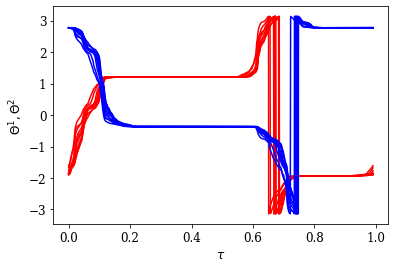

In [10]:
dsigma=-0.5e-3
start=timeit.default_timer()
sigmas2,sols2=janus.cont(omega,beta,gamma,sigma,x0,y0,p0,sigmamin,sigmamax,dsigma,maxnodes=2000)
stop=timeit.default_timer()
print("runtime: ",stop-start)
phases=sols2[-1].y.T.copy()
phi=np.arctan2(phases[:,3*N:],phases[:,2*N:3*N])
theta=np.arctan2(phases[:,N:2*N],phases[:,:N])
plt.xlabel(r'$\tau$')
plt.ylabel(r'$\Theta^1, \Theta^2$')
plt.plot(sols2[-1].x, np.transpose([np.roll(theta[:,i], 100+int(len(theta)/N*i)) for i in range(N)]),color='red')
plt.plot(sols2[-1].x, np.transpose([np.roll(phi[:,i], 100+int(len(theta)/N*i)) for i in range(N)]),color='blue')
plt.show()

In [11]:
Sigmas=[sigmas2[-i] for i in range(1,len(sols2))]+[sigmas[i] for i in range(len(sols))]
Periods=[sols2[-i].p[0] for i in range(1,len(sols2))]+[sols[i].p[0] for i in range(len(sols))]
Ts=[sols2[-i].x for i in range(1,len(sols2))]+[sols[i].x for i in range(len(sols))]
Ys=[sols2[-i].y for i in range(1,len(sols2))]+[sols[i].y for i in range(len(sols))]
np.save(filebase+'lcsigmas.npy',Sigmas)
np.save(filebase+'lcperiods.npy',Periods)
for i in range(len(Sigmas)):
    np.save(filebase+'lctimes_'+str(i)+'.npy',Ts[i])
    np.save(filebase+'lcphases_'+str(i)+'.npy',Ys[i])

### Continue the unstable limit cycle chimera branch

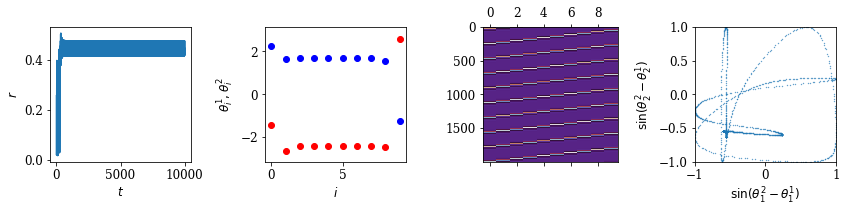

(array([ 0,  7, 14, 21, 28, 35, 42, 49, 56, 63]),)

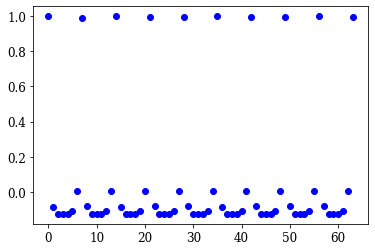

In [12]:
filebase='data/uchimera/'
times=np.load(filebase+'times.npy')
order=np.load(filebase+'order.npy')
phases=np.load(filebase+'phases.npy')
fs=np.load(filebase+'fs.npy')
N=int((len(fs)+2)/4)
sigma0=0.35
omega=1
beta=0.25
gamma=0.1
phi0=np.arctan2(phases[:,N:2*N],phases[:,:N])
phi1=np.arctan2(phases[:,3*N:],phases[:,2*N:3*N])

plt.subplots(1,4,figsize=(12,3))
plt.subplot(1,4,1)
plt.xlabel('$t$')
plt.ylabel('$r$')
plt.plot(times,order)
plt.subplot(1,4,2)
plt.xlabel('$i$')
plt.ylabel(r'$\theta_i^1, \theta_i^2$')
plt.ylim(-np.pi,np.pi)
plt.plot(phi0[-1],'bo')
plt.plot(phi1[-1],'ro')
plt.subplot(1,4,3)
ratio=N/len(phases)
plt.gca().matshow(phi1,aspect=ratio,vmin=-np.pi,vmax=np.pi,cmap='twilight_shifted')
plt.subplot(1,4,4)
plt.xlabel(r'$\sin(\theta_1^2-\theta_1^1)$')
plt.ylabel(r'$\sin(\theta_2^2-\theta_2^1)$')
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.scatter(np.cos(phi1[:,0]-phi0[:,0]),np.cos(phi1[:,1]-phi0[:,1]),s=0.1)
plt.tight_layout()
plt.show()

minds=find_peaks(phases[:,0])[0]
plt.plot(phases[minds,0],'bo')
np.where(phases[minds,0]>0.9)

The algorithm converged to the desired accuracy.
0.350000	5.000e-04	219	109.700171	2	37.120301	
0.350500	5.000e-04	219	110.174768	1	14.031540	
0.351000	5.000e-04	219	110.658256	1	18.708066	
0.351500	5.000e-04	219	111.146225	1	4.704736	
0.352000	5.000e-04	219	111.643792	1	4.950228	
0.352500	5.000e-04	219	112.149812	1	18.449054	
0.353000	5.000e-04	219	112.662251	1	18.926187	
0.353500	5.000e-04	219	113.182031	1	4.679745	


/Users/zack/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:454: RuntimeWarning: Number of calls to function has reached maxfev = 800.
  warnings.warn(errors[info][0], RuntimeWarning)


0.354000	5.000e-04	219	113.661485	1	18.236923	
0.354500	5.000e-04	219	114.251518	1	18.999176	
0.355000	5.000e-04	219	114.799828	1	18.873491	
0.356000	1.000e-03	219	115.924516	1	19.282970	
0.357000	1.000e-03	219	117.095507	1	19.275802	
0.358000	1.000e-03	219	118.315552	1	19.278457	
0.359000	1.000e-03	219	119.590637	1	19.314246	
0.360000	1.000e-03	219	120.927845	1	19.338438	
0.361000	1.000e-03	219	122.340196	1	19.249844	
0.362000	1.000e-03	219	123.831390	1	19.699018	
0.363000	1.000e-03	219	125.417594	1	19.684521	
0.364000	1.000e-03	219	127.117751	1	19.256525	
0.365000	1.000e-03	219	128.951703	1	19.468213	
0.366000	1.000e-03	219	130.948597	1	18.910058	
0.367000	1.000e-03	219	133.168438	1	19.306461	
0.368000	1.000e-03	219	135.659119	1	19.449171	
0.369000	1.000e-03	219	138.528457	1	19.374112	
0.370000	1.000e-03	219	141.957313	1	19.241560	
0.371000	1.000e-03	225	146.307582	3	58.033801	
0.372000	1.000e-03	233	152.574593	3	60.833773	
0.373000	1.000e-03	465	174.960343	2	61.713555	


/Users/zack/Documents/oscillators/snakingoscillators/janus.py:16: RuntimeWarning: invalid value encountered in double_scalars
  sigmat = sigma0 + (sigma - sigma0) * t / t0


The maximum number of mesh nodes is exceeded.
0.373000	5.000e-04	465	174.960343	2	290.350633	
The maximum number of mesh nodes is exceeded.
0.373000	2.500e-04	465	174.960343	2	295.763352	
The maximum number of mesh nodes is exceeded.
0.373000	1.250e-04	465	174.960343	2	289.280431	
The maximum number of mesh nodes is exceeded.
0.373000	6.250e-05	465	174.960343	2	286.258193	
The maximum number of mesh nodes is exceeded.
0.373000	3.125e-05	465	174.960343	2	290.903601	
The maximum number of mesh nodes is exceeded.
0.373000	1.563e-05	465	174.960343	2	176.142057	
0.373016	1.563e-05	465	173.299532	1	30.634000	
The maximum number of mesh nodes is exceeded.
0.373016	7.813e-06	465	173.299532	1	321.106311	
0.373023	7.813e-06	465	174.036479	1	40.689918	
Saddle-node expected at  0.37310525648751725 . Looking for second branch
Found second branch. Continuing. 174.03647936953942 173.3366139052155 174.77342653814532
0.373023	7.813e-06	465	173.336614	1	11.042786	
0.373016	-7.813e-06	465	173.136487	1	41

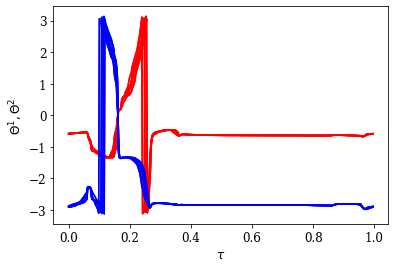

In [13]:
m0=7
m1=14
phases=np.concatenate([np.cos(-np.flip(phi0,axis=0)),np.sin(-np.flip(phi0,axis=0)),np.cos(-np.flip(phi1,axis=0)),np.sin(-np.flip(phi1,axis=0))],axis=1)
p0=times[minds[m1]]-times[minds[m0]]
x0=(times[minds[m0]:minds[m1]]-times[minds[m0]])/p0
y0=phases[minds[m0]:minds[m1]].T
sigma=sigma0
dsigma=0.5e-3
dsigmamax=1e-3
dsigmamin=1e-6
sigmamin=0.25
sigmamax=0.4
start=timeit.default_timer()
sigmas,sols=janus.cont(omega,beta,gamma,sigma,x0,y0,p0,sigmamin,sigmamax,dsigma,maxnodes=2000)
stop=timeit.default_timer()
print("runtime: ",stop-start)
phases=sols[-1].y.T.copy()
phi=np.arctan2(phases[:,3*N:],phases[:,2*N:3*N])
theta=np.arctan2(phases[:,N:2*N],phases[:,:N])
plt.xlabel(r'$\tau$')
plt.ylabel(r'$\Theta^1, \Theta^2$')
plt.plot(sols[-1].x, np.transpose([np.roll(theta[:,i], 100-int(len(theta)/N*i)) for i in range(N)]),color='red')
plt.plot(sols[-1].x, np.transpose([np.roll(phi[:,i], 100-int(len(theta)/N*i)) for i in range(N)]),color='blue')
plt.show()

The algorithm converged to the desired accuracy.
0.350000	-5.000e-04	219	109.700171	2	37.377628	
0.349500	-5.000e-04	219	109.258777	1	18.411739	
0.349000	-5.000e-04	219	108.768205	1	14.233329	
0.348500	-5.000e-04	219	108.311546	1	19.085259	
0.348000	-5.000e-04	219	107.860657	1	18.976589	
0.347500	-5.000e-04	219	107.415460	1	18.419056	


/Users/zack/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:454: RuntimeWarning: Number of calls to function has reached maxfev = 800.
  warnings.warn(errors[info][0], RuntimeWarning)


0.347000	-5.000e-04	219	106.975683	1	18.623992	
0.346500	-5.000e-04	219	106.541349	1	18.841679	
0.346000	-5.000e-04	219	106.112100	1	19.048968	
0.345500	-5.000e-04	219	105.687832	1	14.492546	
0.345000	-5.000e-04	219	105.268311	1	14.206640	
0.344000	-1.000e-03	219	104.439496	1	19.604205	
0.343000	-1.000e-03	219	103.636062	1	19.648036	
0.342000	-1.000e-03	219	102.845324	1	19.228322	
0.341000	-1.000e-03	219	102.071052	1	14.857011	
0.340000	-1.000e-03	219	101.310343	1	10.110154	
0.339000	-1.000e-03	219	100.565119	1	9.710931	
0.338000	-1.000e-03	219	99.832070	1	9.986451	
0.337000	-1.000e-03	219	99.112556	1	10.102812	
0.336000	-1.000e-03	219	98.405072	1	9.658276	
0.335000	-1.000e-03	219	97.709344	1	9.606051	
0.334000	-1.000e-03	219	97.024713	1	9.580606	
0.333000	-1.000e-03	219	96.350700	1	9.579819	
0.332000	-1.000e-03	219	95.686839	1	9.593233	
0.331000	-1.000e-03	219	95.035369	1	5.076790	
0.330000	-1.000e-03	219	94.387880	1	14.512918	
0.329000	-1.000e-03	219	93.751976	1	9.625804	
0.328000	-1

/Users/zack/Documents/oscillators/snakingoscillators/janus.py:16: RuntimeWarning: invalid value encountered in double_scalars
  sigmat = sigma0 + (sigma - sigma0) * t / t0
/Users/zack/opt/anaconda3/lib/python3.7/site-packages/scipy/integrate/_bvp.py:1105: RuntimeWarning: invalid value encountered in greater
  insert_1, = np.nonzero((rms_res > tol) & (rms_res < 100 * tol))
/Users/zack/opt/anaconda3/lib/python3.7/site-packages/scipy/integrate/_bvp.py:1105: RuntimeWarning: invalid value encountered in less
  insert_1, = np.nonzero((rms_res > tol) & (rms_res < 100 * tol))
/Users/zack/opt/anaconda3/lib/python3.7/site-packages/scipy/integrate/_bvp.py:1106: RuntimeWarning: invalid value encountered in greater_equal
  insert_2, = np.nonzero(rms_res >= 100 * tol)


solution changed too much
0.251000	-5.000e-04	321	48.515269	2	193.053604	
0.250500	-5.000e-04	349	47.711852	2	58.495618	
The maximum number of mesh nodes is exceeded.
0.250500	-2.500e-04	349	47.711852	2	254.213312	
The maximum number of mesh nodes is exceeded.
0.250500	-1.250e-04	349	47.711852	2	341.817294	
0.250375	-1.250e-04	349	47.524941	1	30.264391	
0.250250	-1.250e-04	349	47.305394	1	30.348172	
The maximum number of mesh nodes is exceeded.
0.250250	-6.250e-05	349	47.305394	1	215.400386	
0.250188	-6.250e-05	349	47.219227	1	31.042050	
The maximum number of mesh nodes is exceeded.
0.250188	-3.125e-05	349	47.219227	1	254.434955	
0.250156	-3.125e-05	349	47.190832	1	30.826495	
The maximum number of mesh nodes is exceeded.
0.250156	-1.563e-05	349	47.190832	1	269.825932	
The maximum number of mesh nodes is exceeded.
0.250156	-7.813e-06	349	47.190832	1	301.708215	
The maximum number of mesh nodes is exceeded.
0.250156	-3.906e-06	349	47.190832	1	226.523897	
The maximum number of mesh nodes 

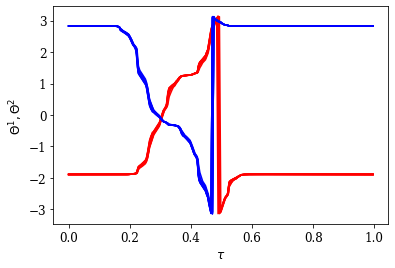

In [14]:
dsigma=-0.5e-3
start=timeit.default_timer()
sigmas2,sols2=janus.cont(omega,beta,gamma,sigma,x0,y0,p0,sigmamin,sigmamax,dsigma,maxnodes=2000)
stop=timeit.default_timer()
print("runtime: ",stop-start)
phases=sols2[-1].y.T.copy()
phi=np.arctan2(phases[:,3*N:],phases[:,2*N:3*N])
theta=np.arctan2(phases[:,N:2*N],phases[:,:N])
plt.xlabel(r'$\tau$')
plt.ylabel(r'$\Theta^1, \Theta^2$')
plt.plot(sols2[-1].x, np.transpose([np.roll(theta[:,i], 100-int(len(theta)/N*i)) for i in range(N)]),color='red')
plt.plot(sols2[-1].x, np.transpose([np.roll(phi[:,i], 100-int(len(theta)/N*i)) for i in range(N)]),color='blue')
plt.show()

In [15]:
Sigmas=[sigmas2[-i] for i in range(1,len(sols2))]+[sigmas[i] for i in range(len(sols))]
Periods=[sols2[-i].p[0] for i in range(1,len(sols2))]+[sols[i].p[0] for i in range(len(sols))]
Ts=[sols2[-i].x for i in range(1,len(sols2))]+[sols[i].x for i in range(len(sols))]
Ys=[sols2[-i].y for i in range(1,len(sols2))]+[sols[i].y for i in range(len(sols))]
np.save(filebase+'lcsigmas.npy',Sigmas)
np.save(filebase+'lcperiods.npy',Periods)
for i in range(len(Sigmas)):
    np.save(filebase+'lctimes_'+str(i)+'.npy',Ts[i])
    np.save(filebase+'lcphases_'+str(i)+'.npy',Ys[i])

### Plot order parameter

10.0

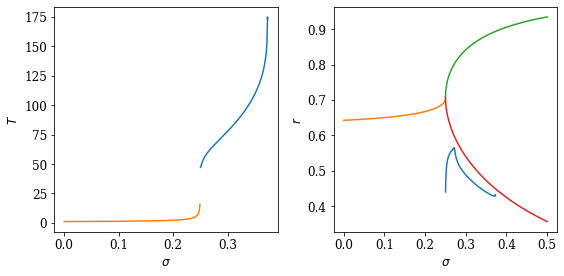

In [7]:
filebase='data/uchimera/'
Sigmas=np.load(filebase+'lcsigmas.npy')
Periods=np.load(filebase+'lcperiods.npy')
Ts=[]
Ys=[]
for i in range(len(Sigmas)):
    Ts.append(np.load(filebase+'lctimes_'+str(i)+'.npy'))
    Ys.append(np.load(filebase+'lcphases_'+str(i)+'.npy'))
N=int(Ys[0].shape[0]/4)
Orders=[]
for i in range(len(Ys)):
    phases=Ys[i].T.copy()
    phi=np.arctan2(phases[:,3*N:],phases[:,2*N:3*N])
    theta=np.arctan2(phases[:,N:2*N],phases[:,:N])
    r=np.abs(np.sum(phases[:,:N]+1j*phases[:,N:2*N],axis=1)+np.sum(phases[:,2*N:3*N]+1j*phases[:,3*N:],axis=1))/(2*N)
    Orders.append(np.sum(r[:-1]*np.diff(Ts[i])))
    
plt.subplots(1,2,figsize=(8,4))
plt.subplot(1,2,1)
plt.xlabel('$\sigma$')
plt.ylabel('$T$')
plt.plot(Sigmas,Periods)
sigmas=np.arange(0,0.25,0.001)
plt.plot(sigmas,[1/(0.75-2*sigma-4*sigma**2)**0.5 for sigma in sigmas])

plt.subplot(1,2,2)
plt.xlabel('$\sigma$')
plt.ylabel('$r$')
plt.plot(Sigmas,Orders)
sigmas=np.arange(0,0.25,0.001)
plt.plot(sigmas,[np.mean(1/(1+0.25*(1+4*sigma-((1-4*sigma)*(3+4*sigma))**0.5*np.tan(2*np.pi/(0.75-2*sigma-4*sigma**2)**0.5*np.arange(0,100)/100*0.25*((1-4*sigma)*(3+4*sigma))**0.5))**2)**0.5) for sigma in sigmas])
sigmas=np.arange(0.25,0.5,0.00001)
plt.plot(sigmas,[(2+2*(1-1/(4*(0.25+sigma)**2))**0.5)**0.5/2 for sigma in sigmas])
plt.plot(sigmas,[(2-2*(1-1/(4*(0.25+sigma)**2))**0.5)**0.5/2 for sigma in sigmas])
plt.tight_layout()
plt.show()

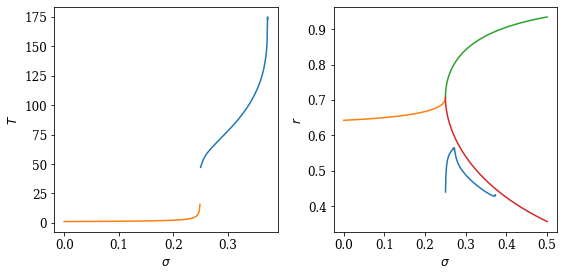

In [17]:
Orders=[]
for i in range(len(Ys)):
    phases=Ys[i].T.copy()
    phi=np.arctan2(phases[:,3*N:],phases[:,2*N:3*N])
    theta=np.arctan2(phases[:,N:2*N],phases[:,:N])
    r=np.abs(np.sum(phases[:,:N]+1j*phases[:,N:2*N],axis=1)+np.sum(phases[:,2*N:3*N]+1j*phases[:,3*N:],axis=1))/(2*N)
    Orders.append(np.sum(r[:-1]*np.diff(Ts[i])))
    
plt.subplots(1,2,figsize=(8,4))
plt.subplot(1,2,1)
plt.xlabel('$\sigma$')
plt.ylabel('$T$')
plt.plot(Sigmas,Periods)
sigmas=np.arange(0,0.25,0.001)
plt.plot(sigmas,[1/(0.75-2*sigma-4*sigma**2)**0.5 for sigma in sigmas])

plt.subplot(1,2,2)
plt.xlabel('$\sigma$')
plt.ylabel('$r$')
plt.plot(Sigmas,Orders)
sigmas=np.arange(0,0.25,0.001)
plt.plot(sigmas,[np.mean(1/(1+0.25*(1+4*sigma-((1-4*sigma)*(3+4*sigma))**0.5*np.tan(2*np.pi/(0.75-2*sigma-4*sigma**2)**0.5*np.arange(0,100)/100*0.25*((1-4*sigma)*(3+4*sigma))**0.5))**2)**0.5) for sigma in sigmas])
sigmas=np.arange(0.25,0.5,0.00001)
plt.plot(sigmas,[(2+2*(1-1/(4*(0.25+sigma)**2))**0.5)**0.5/2 for sigma in sigmas])
plt.plot(sigmas,[(2-2*(1-1/(4*(0.25+sigma)**2))**0.5)**0.5/2 for sigma in sigmas])
plt.tight_layout()
plt.savefig('diagram.pdf')
plt.show()

In [22]:
def funjac(ts,Xts,p):
    return p[0]*np.transpose([janus.janus_jac(p[0]*ts[i],Xts[:,i], N, omega, sigma, beta, gamma,sigma,-1) for i in range(len(ts))],(2,1,0)),  np.transpose([fun(ts,Xts,p)/p[0]],(1,0,2))

funjac(x0,y0,[p0])[0].shape

(40, 40, 687)

In [91]:
omega=1
beta=0.25
gamma=0.1

m=np.argmin(np.abs(Sigmas-0.35))
sigma=Sigmas[m]
x0=Ts[m]
y0=Ys[m]
p0=Periods[m]
bc=y0[0,0]
maxnodes=5000
tol=1e-2
bctol=1e-2
dsigma=1e-4

imp.reload(janus)
def fun(ts,Xts,p):
    return p[0]*np.transpose([janus.janus(p[0]*ts[i],Xts[:,i], N, omega, sigma, beta, gamma,sigma,-1) for i in range(len(ts))])
def pbc(xa,xb,p):
    return np.concatenate([xb-xa,[xa[0]-bc]])
def funjac(ts,Xts,p):
    return p[0]*np.transpose([janus.janus_jac(p[0]*ts[i],Xts[:,i], N, omega, sigma, beta, gamma,sigma,-1) for i in range(len(ts))],(1,2,0)),  np.transpose([fun(ts,Xts,p)/p[0]],(1,0,2))
    
start2=timeit.default_timer()
sol=solve_bvp(fun, pbc, x0, y0, p=np.array([p0]), fun_jac=funjac,max_nodes=maxnodes,tol=tol,bc_tol=bctol)
# sol=solve_bvp(fun, pbc, x0, y0, p=np.array([p0]),max_nodes=maxnodes,tol=tol,bc_tol=bctol)
stop2=timeit.default_timer()
print(sol.message,flush=True)
print('%f\t%.3e\t%i\t%f\t%i\t%f\t'%(sigma, dsigma,len(sol.x),sol.p[0],sol.niter,stop2-start2),end='\n',flush=True)

The algorithm converged to the desired accuracy.
0.350000	1.000e-04	249	109.697183	3	8.815315	


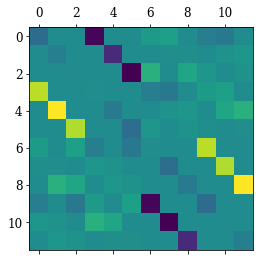

In [86]:
imp.reload(janus)
thetas=np.array([0,2*np.pi/3,2*2*np.pi/3])+np.pi/4
phis=np.array([0,2*np.pi/3,2*2*np.pi/3])+np.pi/4
jac=janus.janus_jac(0,np.concatenate([np.cos(thetas), np.sin(thetas),np.cos(phis),np.sin(phis)]), 3, omega, sigma, beta, gamma,sigma,-1)
plt.matshow(jac)

In [72]:
print(jac[0])

[-0.28905445 -0.         -0.         -1.01716334 -0.         -0.
  0.125       0.175       0.         -0.125      -0.175      -0.        ]


In [85]:
print(jac[:,0])

[-0.28905445 -0.         -0.          0.89216334  0.          0.
  0.125       0.02344555  0.         -0.125       0.0875      0.        ]
